In [2]:
import pandas as pd
import numpy as np
from notebooks.utils import break_datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN
import joblib
import zipfile
import os


warnings.filterwarnings('ignore')

In [3]:
# Specify the ZIP file name
zip_filename = "../dataset/filtered.zip"

# Extract the model file from the ZIP archive
with zipfile.ZipFile(zip_filename, "r") as archive:
    # Extract the model file (named "your_model.pkl" in this example)
    archive.extract("filtered.pkl")
    
# Load the model
df = joblib.load("filtered.pkl")  # Replace with "pickle.load" if you used pickle

os.remove("filtered.pkl")

In [4]:
df.head()

,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
11096,0,2016-01-01 08:00:00,0.0,0,Education,7432,2008.0,NaN,20.6,NaN,20.0,0.0,1018.1,0.0,0.0
11097,1,2016-01-01 08:00:00,0.0,0,Education,2720,2004.0,NaN,20.6,NaN,20.0,0.0,1018.1,0.0,0.0
11098,2,2016-01-01 08:00:00,0.0,0,Education,5376,1991.0,NaN,20.6,NaN,20.0,0.0,1018.1,0.0,0.0
11099,3,2016-01-01 08:00:00,0.0,0,Education,23685,2002.0,NaN,20.6,NaN,20.0,0.0,1018.1,0.0,0.0
11100,4,2016-01-01 08:00:00,0.0,0,Education,116607,1975.0,NaN,20.6,NaN,20.0,0.0,1018.1,0.0,0.0


In [5]:
df['log_meter_reading']=np.log1p(df['meter_reading'])

In [6]:
df

,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,log_meter_reading
11096,0,2016-01-01 08:00:00,0.000,0,Education,7432,2008.0,NaN,20.6,NaN,20.0,0.0,1018.1,0.0,0.0,0.000000
11097,1,2016-01-01 08:00:00,0.000,0,Education,2720,2004.0,NaN,20.6,NaN,20.0,0.0,1018.1,0.0,0.0,0.000000
11098,2,2016-01-01 08:00:00,0.000,0,Education,5376,1991.0,NaN,20.6,NaN,20.0,0.0,1018.1,0.0,0.0,0.000000
11099,3,2016-01-01 08:00:00,0.000,0,Education,23685,2002.0,NaN,20.6,NaN,20.0,0.0,1018.1,0.0,0.0,0.000000
11100,4,2016-01-01 08:00:00,0.000,0,Education,116607,1975.0,NaN,20.6,NaN,20.0,0.0,1018.1,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12020208,1444,2016-12-30 18:00:00,8.625,15,Entertainment/public assembly,19619,1914.0,NaN,-1.7,NaN,-6.1,-1.0,1004.7,290.0,11.3,2.264364
12020209,1445,2016-12-30 18:00:00,5.775,15,Education,4298,NaN,NaN,-1.7,NaN,-6.1,-1.0,1004.7,290.0,11.3,1.913239
12020210,1446,2016-12-30 18:00:00,0.000,15,Entertainment/public assembly,11265,1997.0,NaN,-1.7,NaN,-6.1,-1.0,1004.7,290.0,11.3,0.000000
12020211,1447,2016-12-30 18:00:00,166.775,15,Lodging/residential,29775,2001.0,NaN,-1.7,NaN,-6.1,-1.0,1004.7,290.0,11.3,5.122624


In [7]:
site_df = df.groupby(['site_id','timestamp']).log_meter_reading.mean().reset_index()


In [8]:
site_df.groupby('site_id').count()

,timestamp,log_meter_reading
site_id,,
0,2871,2871
1,2871,2871
2,2871,2871
3,2871,2871
4,2871,2871
5,2871,2871
6,2871,2871
7,2871,2871
8,2871,2871


In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose each time series to extract trend component

trend_data = pd.DataFrame(0, index=range(1, 8785), columns=[f'Site_ID_{site_id}_Trend' for site_id in site_df['site_id'].unique()])

# Iterate over each site
for site_id in site_df['site_id'].unique():
    site_data = site_df[site_df['site_id'] == site_id]
    decomposition = seasonal_decompose(site_data['log_meter_reading'], model='additive', period=720)

    # Interpolate missing values in the trend component
    trend = decomposition.trend.dropna()
    
    # Assign the trend component to the appropriate column in trend_data
    trend_data[f'Site_ID_{site_id}_Trend'].iloc[:len(trend)] = trend.values



trend_data


,Site_ID_0_Trend,Site_ID_1_Trend,Site_ID_2_Trend,Site_ID_3_Trend,Site_ID_4_Trend,Site_ID_5_Trend,Site_ID_6_Trend,Site_ID_7_Trend,Site_ID_8_Trend,Site_ID_9_Trend,Site_ID_10_Trend,Site_ID_11_Trend,Site_ID_12_Trend,Site_ID_13_Trend,Site_ID_14_Trend,Site_ID_15_Trend
1,0.016441,4.713554,4.452709,3.925722,4.408160,3.219161,4.729799,6.373610,2.570244,4.385394,4.162407,5.462348,4.294141,4.763455,4.669308,4.327931
2,0.016444,4.713901,4.453133,3.925901,4.408863,3.219243,4.730467,6.373894,2.568405,4.386396,4.162760,5.462832,4.294730,4.764056,4.669936,4.328277
3,0.016447,4.714233,4.453560,3.926119,4.409513,3.219326,4.731141,6.374160,2.566568,4.387431,4.163082,5.463154,4.295377,4.764672,4.670555,4.328664
4,0.016388,4.714534,4.453966,3.926345,4.410148,3.219303,4.731797,6.374367,2.564724,4.388446,4.163392,5.463447,4.296024,4.765263,4.671149,4.329051
5,0.016328,4.714806,4.454324,3.926555,4.410710,3.219165,4.732388,6.374469,2.562860,4.389444,4.163678,5.463685,4.296637,4.765795,4.671715,4.329387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8780,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8782,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8783,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


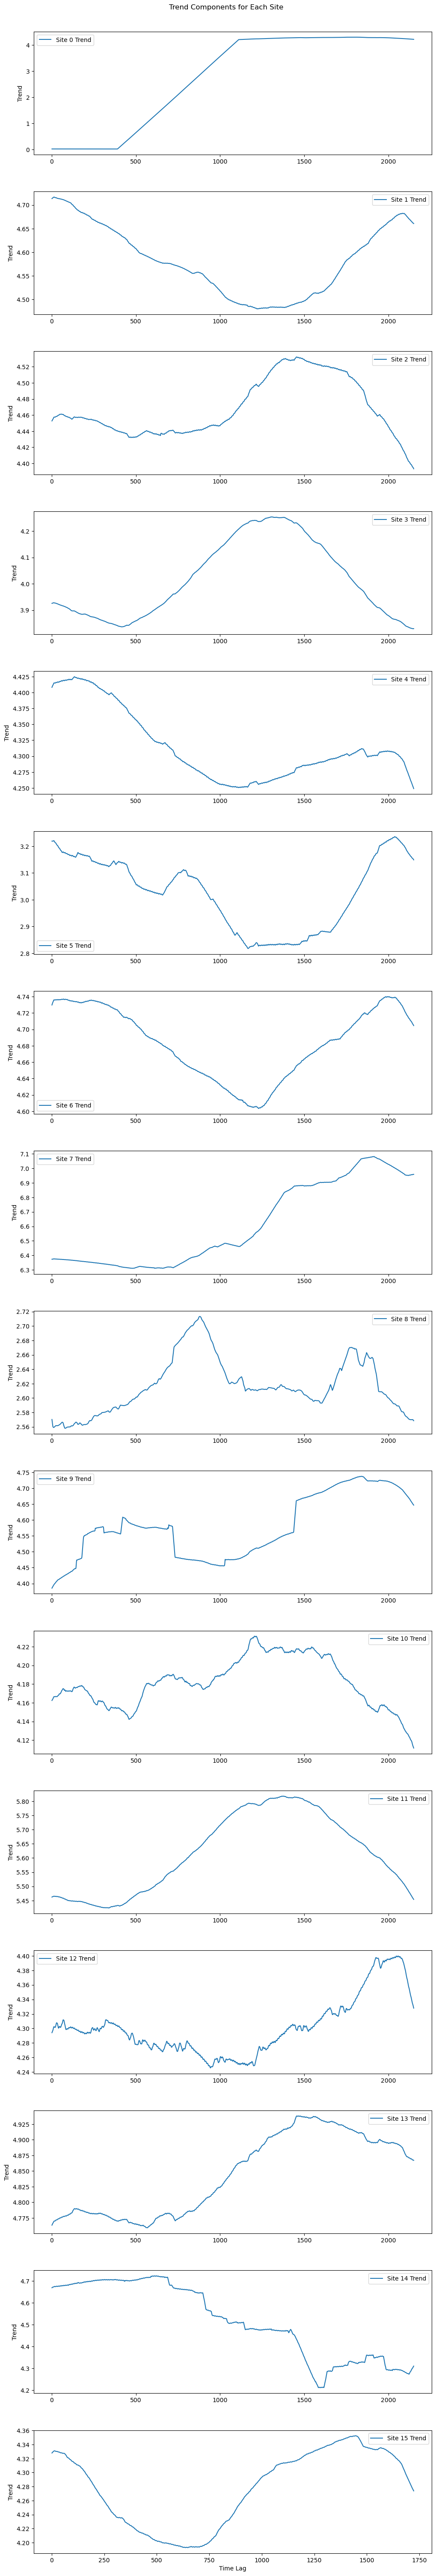

In [10]:
# Plot trends for all sites
fig, ax = plt.subplots(len(site_df['site_id'].unique()), 1, figsize=(12, 4 * len(site_df['site_id'].unique())))

for i, site_id in enumerate(site_df['site_id'].unique()):
    site_trend_data = trend_data[trend_data[f'Site_ID_{site_id}_Trend'] > 0][f'Site_ID_{site_id}_Trend']
    ax[i].plot(site_trend_data, label=f'Site {site_id} Trend')
    ax[i].set_ylabel('Trend')
    ax[i].legend()

plt.xlabel('Time Lag')
plt.suptitle('Trend Components for Each Site')
plt.subplots_adjust(top=0.97, bottom=0.05, hspace=0.3)
plt.show()

In [11]:
df2 = pd.read_csv('/Users/goksuuzunturk/Desktop/DI 502 Project/FilteredDataset/train.csv').drop('Unnamed: 0',axis=1)
df2[df2['site_id']==0].meter_reading *= 0.293014534
df2['log_meter_reading']=np.log1p(df2['meter_reading'])
df2 = break_datetime(df2)
site_df2 = df2.groupby(['weekofyear', 'site_id']).log_meter_reading.mean().reset_index()


In [12]:
site_df2[site_df2['site_id'] == 0].log_meter_reading

0      3.838095
16     3.813226
32     2.936561
48     2.724147
64     2.901074
80     2.945980
96     2.412073
111    2.416037
126    2.764178
141    3.915879
156    3.977941
171    3.699956
186    4.036439
202    3.824975
218    3.801356
234    3.774369
250    5.128279
266    3.956621
282    3.735719
298    5.170810
314    5.216486
330    5.224326
346    5.232353
362    5.257976
378    5.272797
394    5.272830
410    5.278739
426    5.276676
442    5.277452
458    5.306305
474    5.272693
490    5.240638
506    5.307343
522    5.355979
538    5.355886
554    5.334959
570    5.367863
586    5.360664
602    5.340713
618    5.281687
634    5.318313
650    5.288468
666    5.282998
682    5.310704
698    5.267869
714    5.269153
730    5.197597
746    5.290356
762    5.274687
778    5.192784
794    5.123706
810    5.079478
826    3.924941
Name: log_meter_reading, dtype: float64

In [13]:
time_series_data = pd.DataFrame(0, index=range(1, 54), columns=[f'Site_ID_{site_id}_Trend' for site_id in site_df['site_id'].unique()])

for i, site_id in enumerate(site_df2['site_id'].unique()):
    site_data = site_df2[site_df2['site_id'] == site_id]
    time_series_data[f'Site_ID_{site_id}_Trend'].iloc[:len(site_data)] = site_data.log_meter_reading

time_series_data

,Site_ID_0_Trend,Site_ID_1_Trend,Site_ID_2_Trend,Site_ID_3_Trend,Site_ID_4_Trend,Site_ID_5_Trend,Site_ID_6_Trend,Site_ID_7_Trend,Site_ID_8_Trend,Site_ID_9_Trend,Site_ID_10_Trend,Site_ID_11_Trend,Site_ID_12_Trend,Site_ID_13_Trend,Site_ID_14_Trend,Site_ID_15_Trend
1,3.838095,4.517748,4.290937,3.862706,4.114262,2.683423,4.588073,7.397695,2.603105,4.437415,3.961692,5.288591,3.891612,4.595129,4.662992,4.152126
2,3.813226,4.567847,4.357643,3.864594,4.125609,2.850066,4.616369,7.415506,2.726213,4.474849,4.060824,5.252202,4.106915,4.627373,4.708785,4.177369
3,2.936561,4.597538,4.303259,3.961161,4.149749,2.697436,4.605754,7.416249,2.713933,4.536536,4.008921,5.198519,4.100439,4.652168,4.775494,4.236600
4,2.724147,4.583976,4.317450,3.885566,4.183714,2.824167,4.556839,7.392366,2.674771,4.565643,4.066153,5.212519,4.095328,4.665036,4.771433,4.293366
5,2.901074,4.592049,4.345774,3.847975,4.210603,2.814518,4.596018,7.364270,2.635734,4.572512,4.053711,5.222830,3.902645,4.656828,4.764930,4.301741
6,2.945980,4.598992,4.298759,3.956235,4.190647,2.781918,4.639004,7.403861,2.759421,4.555370,3.991705,5.202331,3.959534,4.683025,4.805420,4.314431
7,2.412073,4.568452,4.299681,3.886609,4.155570,2.524841,4.635299,7.404559,2.678412,4.584674,3.880409,5.154352,4.128206,4.656526,4.772736,4.149180
8,2.416037,4.589628,4.301564,3.840230,4.185390,2.767192,4.610689,7.386788,2.656798,4.558371,3.902749,5.204731,4.118650,4.655102,4.778921,4.280176
9,2.764178,4.582831,4.285849,3.824522,4.175138,2.743051,4.610712,7.389757,2.674126,4.591931,3.891776,5.201628,4.021284,4.654485,4.760871,4.241750
10,3.915879,4.541272,4.222954,3.717819,4.196686,2.755515,4.565909,7.357444,2.723124,4.565086,3.837030,5.206821,3.875268,4.630914,4.625967,4.226610


In [14]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Assuming 'trend_data' is your DataFrame with trend data
# Replace it with your actual DataFrame if needed

# Extract the trend data from the DataFrame
time_series_data2 = time_series_data.loc[(time_series_data != 0).all(axis=1)].T
X = time_series_data2.values

# Scale the time series data (optional but can be beneficial)
X_scaled = TimeSeriesScalerMeanVariance().fit_transform(X)

# Specify the number of clusters (you may adjust this)
num_clusters = 7

# Apply TimeSeriesKMeans clustering
kmeans = TimeSeriesKMeans(n_clusters=num_clusters, metric="dtw", verbose=True)
clusters = kmeans.fit_predict(X_scaled)

# Add the cluster labels to the DataFrame
time_series_data2['cluster'] = clusters

time_series_data2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

6.165 --> 3.914 --> 3.914 --> 


[Parallel(n_jobs=1)]: Done 112 out of 112 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 112 out of 112 | elapsed:    0.0s finished


,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,cluster
Site_ID_0_Trend,3.838095,3.813226,2.936561,2.724147,2.901074,2.945980,2.412073,2.416037,2.764178,3.915879,...,5.340713,5.281687,5.318313,5.288468,5.282998,5.310704,5.267869,5.269153,5.197597,2
Site_ID_1_Trend,4.517748,4.567847,4.597538,4.583976,4.592049,4.598992,4.568452,4.589628,4.582831,4.541272,...,4.329139,4.344625,4.398861,4.433187,4.443891,4.569799,4.531125,4.465983,4.471682,1
Site_ID_2_Trend,4.290937,4.357643,4.303259,4.317450,4.345774,4.298759,4.299681,4.301564,4.285849,4.222954,...,4.330938,4.308700,4.293848,4.326301,4.340554,4.293429,4.268491,4.286841,4.182124,3
Site_ID_3_Trend,3.862706,3.864594,3.961161,3.885566,3.847975,3.956235,3.886609,3.840230,3.824522,3.717819,...,3.762645,3.723963,3.618409,3.757227,3.631520,3.646542,3.647463,3.707504,3.692682,0
Site_ID_4_Trend,4.114262,4.125609,4.149749,4.183714,4.210603,4.190647,4.155570,4.185390,4.175138,4.196686,...,4.086076,4.097702,4.075707,4.089057,4.104555,4.097068,4.104305,4.102636,4.002227,1
Site_ID_5_Trend,2.683423,2.850066,2.697436,2.824167,2.814518,2.781918,2.524841,2.767192,2.743051,2.755515,...,2.557870,2.561730,2.596404,2.588844,2.306813,2.607055,2.673657,2.707763,2.841980,6
Site_ID_6_Trend,4.588073,4.616369,4.605754,4.556839,4.596018,4.639004,4.635299,4.610689,4.610712,4.565909,...,4.561692,4.562154,4.566529,4.589922,4.568054,4.484268,4.585178,4.584875,4.505826,1
Site_ID_7_Trend,7.397695,7.415506,7.416249,7.392366,7.364270,7.403861,7.404559,7.386788,7.389757,7.357444,...,7.168913,7.176061,7.167565,7.203685,7.219120,7.216907,7.274837,7.325554,7.364446,1
Site_ID_8_Trend,2.603105,2.726213,2.713933,2.674771,2.635734,2.759421,2.678412,2.656798,2.674126,2.723124,...,2.891097,2.821040,2.846821,2.855222,2.800083,2.873101,2.838160,2.715704,2.632252,3
Site_ID_9_Trend,4.437415,4.474849,4.536536,4.565643,4.572512,4.555370,4.584674,4.558371,4.591931,4.565086,...,4.597533,4.601684,4.639683,4.609322,4.599008,4.599441,4.569689,4.567320,4.436893,3


In [15]:
time_series_data2['cluster']

Site_ID_0_Trend     2
Site_ID_1_Trend     1
Site_ID_2_Trend     3
Site_ID_3_Trend     0
Site_ID_4_Trend     1
Site_ID_5_Trend     6
Site_ID_6_Trend     1
Site_ID_7_Trend     1
Site_ID_8_Trend     3
Site_ID_9_Trend     3
Site_ID_10_Trend    5
Site_ID_11_Trend    0
Site_ID_12_Trend    4
Site_ID_13_Trend    3
Site_ID_14_Trend    5
Site_ID_15_Trend    5
Name: cluster, dtype: int64